In [1]:
import importlib
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import interpolate

In [2]:
from multi_loc import covariance, assimilate, utilities

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [5]:
dimension = 2**9
print(dimension)
rho0_l = 0.09
rho0_s = 0.003

# rho0_l = 0.2
# rho0_m = 0.04
# rho0_s = 0.004
# rho0 = 0.2
# dx = 0.25
dx = 1/dimension

# obs_size = int(dimension/2)
# H = assimilate.random_H(dimension, obs_size)

H = np.eye(dimension)[::2]
obs_size = H.shape[0]

rho = np.arange(dimension, dtype=float)
rho = np.minimum(rho, (dimension - rho) % dimension)
rho = rho*dx

512


In [9]:
eig_val_l, eig_vec_l, P_l, sort_index = covariance.generate_circulant(
    dimension, dx, rho0_l, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('long variance: ', eig_val_l.mean())
eig_val_l = eig_val_l / eig_val_l.mean()
sort_index = np.argsort(sort_index)
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]
P_l = eig_vec_l @ np.diag(eig_val_l) @ eig_vec_l.conj().T
P_l = P_l.real

# eig_val_m, eig_vec_m, P_m, sort_index = covariance.generate_circulant(
#     dimension, dx, rho0_m, covariance.fft_sqd_exp_1d,
#     return_Corr=True, return_sort_ind=True)
# print('medium variance: ', eig_val_m.mean())
# eig_val_m = eig_val_m / eig_val_m.mean()
# sort_index = np.argsort(sort_index)
# eig_val_m = eig_val_m[sort_index]
# eig_vec_m = eig_vec_m[:, sort_index]
# P_m = eig_vec_m @ np.diag(eig_val_m) @ eig_vec_m.conj().T
# P_m = P_m.real

eig_val_s, eig_vec_s, P_s, sort_index = covariance.generate_circulant(
    dimension, dx, rho0_s, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('short variance: ', eig_val_s.mean())
eig_val_s = eig_val_s / eig_val_s.mean()
sort_index = np.argsort(sort_index)
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]
P_s = eig_vec_s @ np.diag(eig_val_s) @ eig_vec_s.conj().T
P_s = P_s.real
#P_s = P_s/P_s.max()

# al = 0.40
# am = 0.40
# eig_val = (1 - al - am) * eig_val_s + am * eig_val_m + al * eig_val_l

al = 0.5
eig_val = (1 - al) * eig_val_s + al * eig_val_l
eig_vec = eig_vec_l.copy()

eig_val = eig_val / eig_val.mean()

sort_index = np.argsort(eig_val)[::-1]
eig_val = eig_val[sort_index]
eig_vec = eig_vec[:, sort_index]

P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
P = P.real

sort_index = np.argsort(eig_val_l)[::-1]
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]

# sort_index = np.argsort(eig_val_m)[::-1]
# eig_val_m = eig_val_m[sort_index]
# eig_vec_m = eig_vec_m[:, sort_index]

sort_index = np.argsort(eig_val_s)[::-1]
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]

R_sig = 1
R = R_sig * np.eye(obs_size)

trans_mats_true = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)


trans_mats_long = assimilate.transformation_matrices(
    H, eig_val_p=eig_val_l, eig_vec_p=eig_vec_l,
    R=R, return_Ts=True)

# trans_mats_med = assimilate.transformation_matrices(
#     H, eig_val_p=eig_val_m, eig_vec_p=eig_vec_m,
#     R=R, return_Ts=True)


trans_mats_short = assimilate.transformation_matrices(
    H, eig_val_p=eig_val_s, eig_vec_p=eig_vec_s,
    R=R, return_Ts=True)


for key, val in trans_mats_true.items():
    exec(key + '=val')
for key, val in trans_mats_long.items():
    exec(key+'_l' + '=val')
# for key, val in trans_mats_med.items():
#     exec(key+'_m' + '=val')
for key, val in trans_mats_short.items():
    exec(key+'_s' + '=val')

long variance:  1.0
short variance:  0.999998602378286


Log10(condition):  6.5477037050343725


Text(0.5, 0.98, 'Eigenvalues P_s')

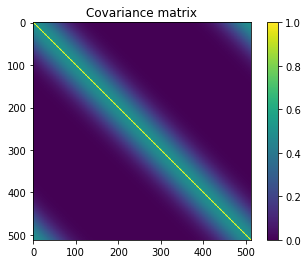

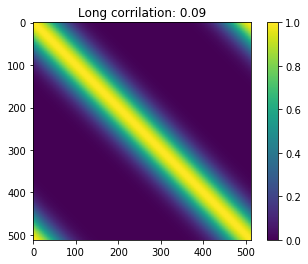

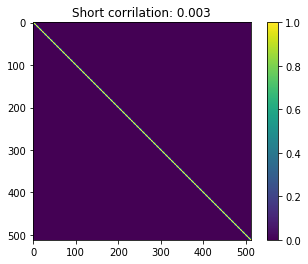

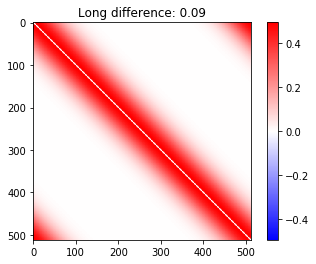

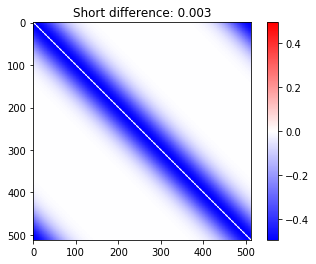

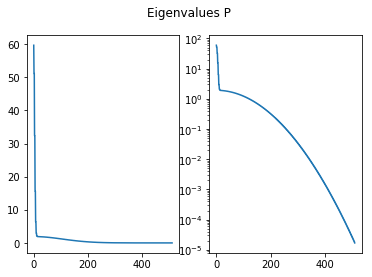

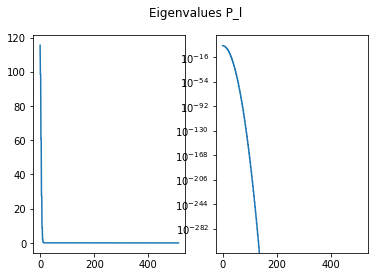

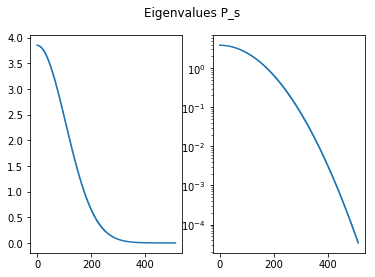

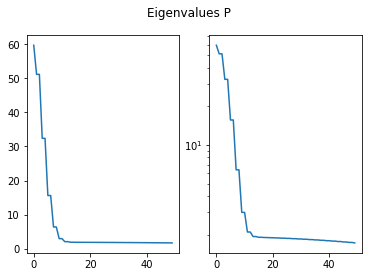

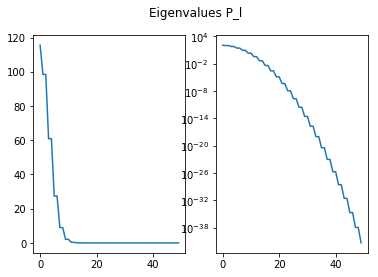

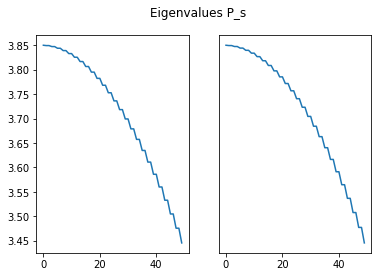

In [12]:
imshow(P, title='Covariance matrix', vmin=0, vmax=1)
imshow(P_l, title=f'Long corrilation: {rho0_l}', vmin=0, vmax=1)
# imshow(P_m, title=f'Medium corrilation: {rho0_l}', vmin=0, vmax=1)
imshow(P_s, title=f'Short corrilation: {rho0_s}', vmin=0, vmax=1)

error_l = P_l - P
# error_m = P_m - P
error_s = P_s - P

# vmax = np.max([np.abs(error_l).max(),
#                np.abs(error_s).max(),
#                np.abs(error_m).max()])

vmax = np.max([np.abs(error_l).max(),
               np.abs(error_s).max()])

imshow(error_l, title=f'Long difference: {rho0_l}',
       vmin=-vmax, vmax=vmax, cmap='bwr')
# imshow(error_m, title=f'medium difference: {rho0_m}',
#        vmin=-vmax, vmax=vmax, cmap='bwr')
imshow(error_s, title=f'Short difference: {rho0_s}',
       vmin=-vmax, vmax=vmax, cmap='bwr')
print('Log10(condition): ',
      np.log10(np.linalg.cond(P)))

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val)
ax[1].semilogy(eig_val)
plt.suptitle('Eigenvalues P')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_l)
ax[1].semilogy(eig_val_l)
plt.suptitle('Eigenvalues P_l')

# fig, ax = plt.subplots(1, 2)
# ax[0].plot(eig_val_m)
# ax[1].semilogy(eig_val_m)
# plt.suptitle('Eigenvalues P_m')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_s)
ax[1].semilogy(eig_val_s)
plt.suptitle('Eigenvalues P_s')

plot_sig_num = 50
fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val[:plot_sig_num])
ax[1].semilogy(eig_val[:plot_sig_num])
plt.suptitle('Eigenvalues P')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_l[:plot_sig_num])
ax[1].semilogy(eig_val_l[:plot_sig_num])
plt.suptitle('Eigenvalues P_l')

# fig, ax = plt.subplots(1, 2)
# ax[0].plot(eig_val_m[:plot_sig_num])
# ax[1].semilogy(eig_val_m[:plot_sig_num])
# plt.suptitle('Eigenvalues P_m')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_s[:plot_sig_num])
ax[1].semilogy(eig_val_s[:plot_sig_num])
plt.suptitle('Eigenvalues P_s')

# R^{-1/2} H P^{1/2} = U S VT

In [13]:
trans_mats = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)

for key, val in trans_mats.items():
    print(key)
    exec(key + '=val')

P_sqrt
P_inv_sqrt
R_sqrt
R_inv_sqrt
U
S
VT
H
Tx
Tx_inv
Ty
Ty_inv


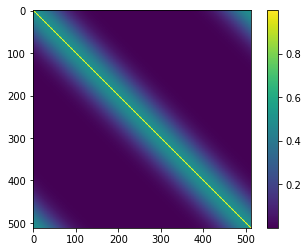

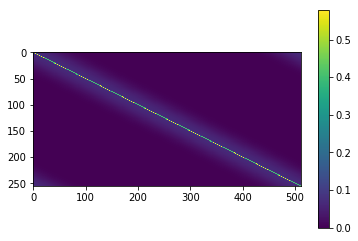

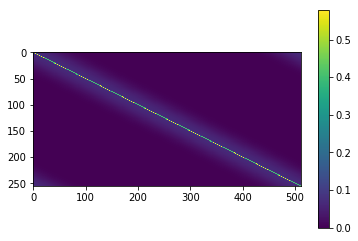

In [14]:
imshow(P_sqrt @ P_sqrt)
imshow(H @ P_sqrt)
imshow(U @ S @ VT)

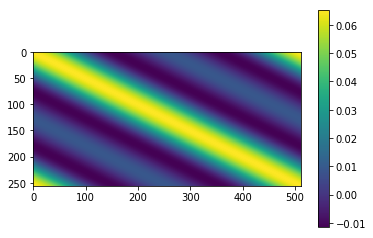

In [15]:
sig_num = 5
imshow(U[:, :sig_num] @ S[:sig_num, :sig_num] @ VT[:sig_num])

In [16]:
ens_size = 30
X = assimilate.generate_ensemble(ens_size=ens_size,
                                       mu=np.zeros(dimension),
                                       eig_val=eig_val,
                                       eig_vec=eig_vec
                                       )
P_sample = np.cov(X)

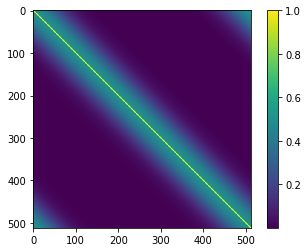

In [17]:
imshow(P)

In [24]:
2**6

64

/home/travis/miniconda3/envs/loc/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


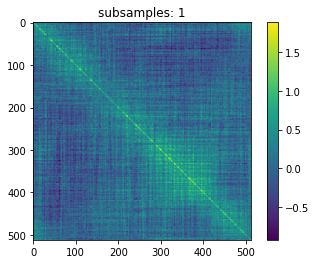

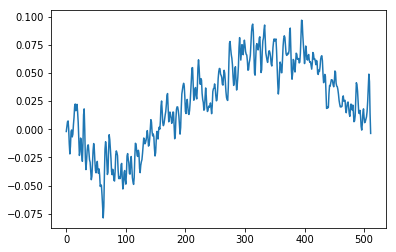

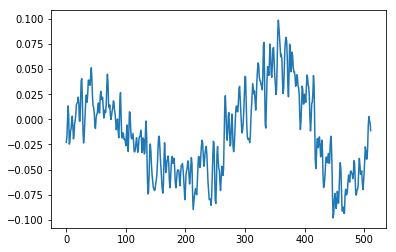

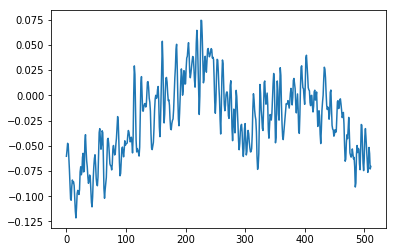

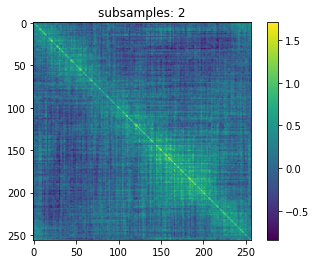

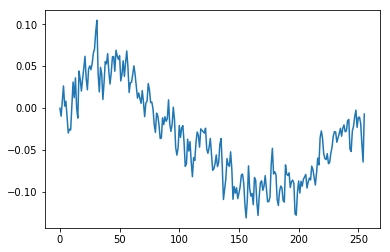

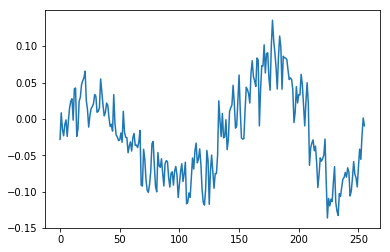

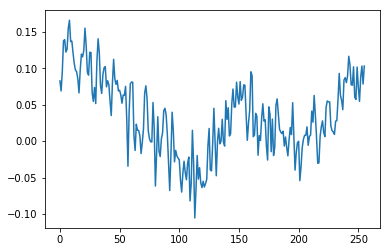

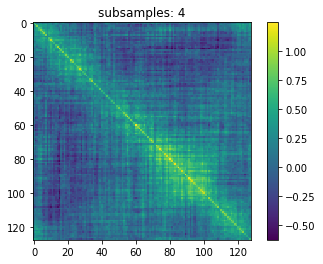

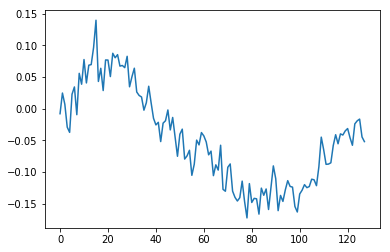

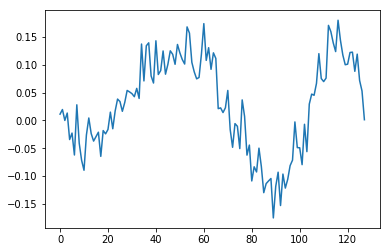

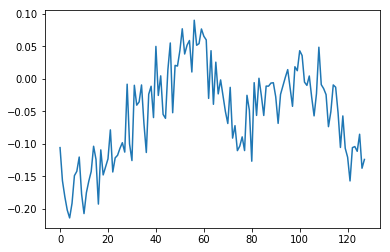

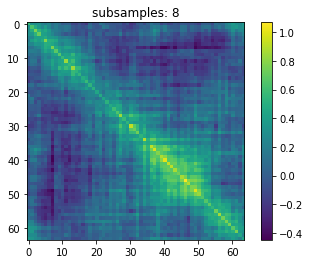

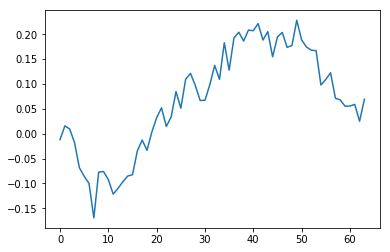

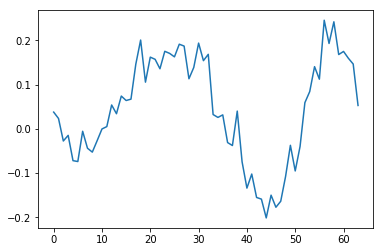

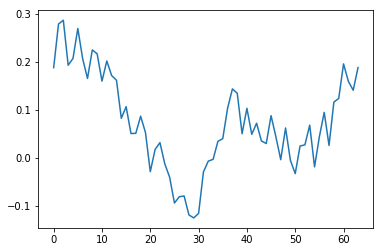

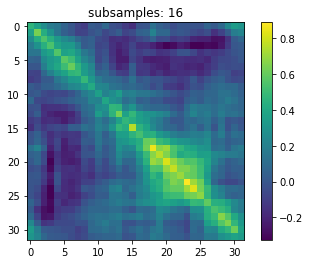

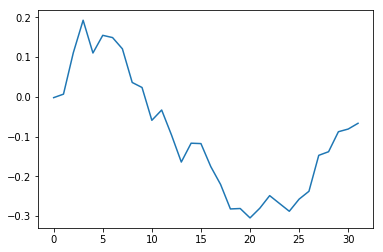

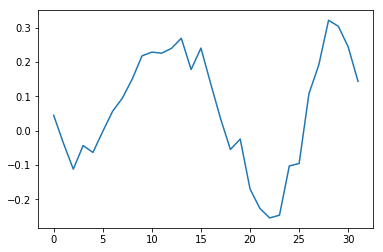

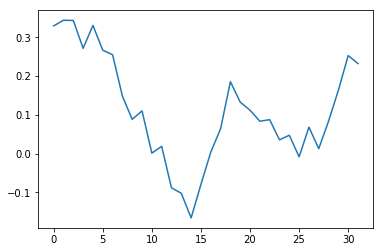

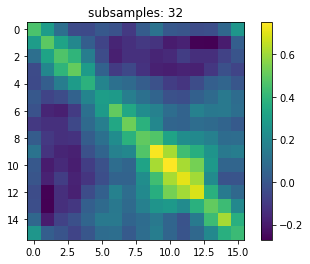

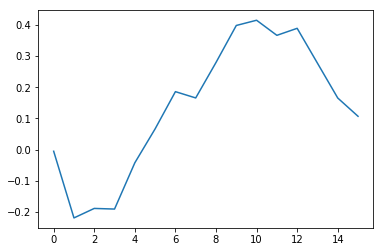

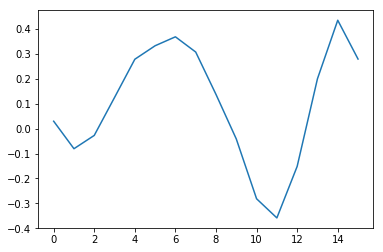

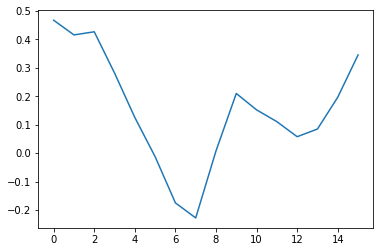

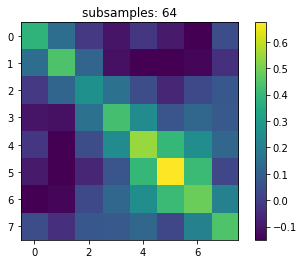

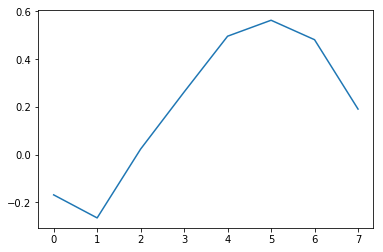

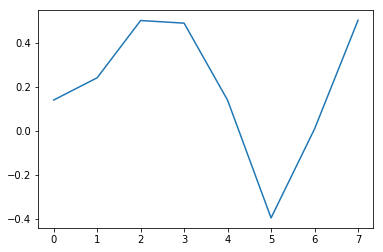

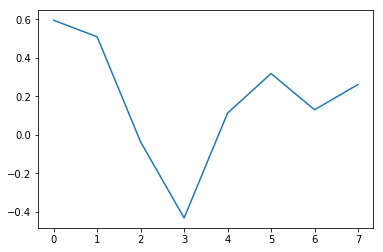

In [26]:
for n in range(7):
    subnum = 2**n
    X_subgrid = X.reshape(dimension // subnum, subnum, ens_size)
    X_subgrid = X_subgrid.mean(axis=1)
    P_sample_subgrid = np.cov(X_subgrid)
    imshow(P_sample_subgrid, title=f'subsamples: {subnum}')
    u, s, vt = np.linalg.svd(P_sample_subgrid)
    for ii in range(3):
        plt.figure()
        plt.plot(vt[ii])

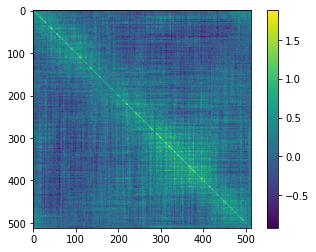

In [18]:
imshow(P_sample)

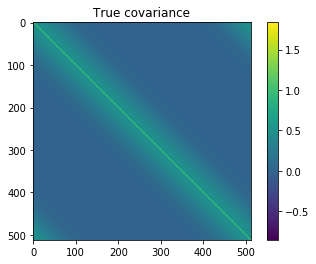

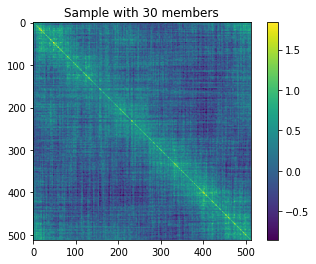

In [240]:
vmax = np.max([P_sample.max(), P.max()])
vmin = np.min([P_sample.min(), P.min()])

imshow(P, vmax=vmax, vmin=vmin, title='True covariance')
imshow(P_sample, vmax=vmax, vmin=vmin, title='Sample with 30 members')

In [241]:
def loc_with_trans(P_sample, P_sqrt, P_inv_sqrt, VT):
    P_til_loc = np.diag(np.diag(
        VT @ P_inv_sqrt @ P_sample @ P_inv_sqrt @ VT.T))
    P_sample_loc = P_sqrt @ VT.T @ P_til_loc @ VT @ P_sqrt
    return P_sample_loc

In [242]:
def test_trans_matrices(P, P_sample, P_sqrt, P_inv_sqrt, VT, title):
    P_sample_loc = loc_with_trans(P_sample=P_sample,
                                  P_sqrt=P_sqrt,
                                  P_inv_sqrt=P_inv_sqrt,
                                  VT=VT)
    vmax = np.max([P_sample.max(), P_sample_loc.max(), P.max()])
    vmin = np.min([P_sample.min(), P_sample_loc.min(), P.min()])

    imshow(P, vmax=vmax, vmin=vmin, title='truth')
    imshow(P_sample, vmax=vmax, vmin=vmin, title='sample')
    imshow(P_sample_loc, vmax=vmax, vmin=vmin, title=title)
    
    error_sample = P - P_sample
    error_loc = P - P_sample_loc
    L2_sample = np.round(np.linalg.norm(error_sample, ord=2), decimals=1)
    L2_loc = np.round(np.linalg.norm(error_loc, ord=2), decimals=1)
    vmax = np.max([np.abs(error_sample).max(),
                   np.abs(error_loc).max()])
    imshow(error_sample, vmax=vmax, vmin=-vmax,
           title='sample error' + f'; L2: {L2_sample}', cmap='bwr')
    imshow(error_loc, vmax=vmax, vmin=-vmax,
           title=title +' error' + f'; L2: {L2_loc}', cmap='bwr')
    return P_sample_loc

In [243]:
P_sample_loc = loc_with_trans(P_sample=P_sample,
                              P_sqrt=P_sqrt,
                              P_inv_sqrt=P_inv_sqrt,
                              VT=VT)

array([[0.97195735, 0.87723709, 0.68633378, ..., 0.54071232, 0.68130443,
        0.87412509],
       [0.87723709, 0.97623993, 0.88389399, ..., 0.47722312, 0.5362124 ,
        0.68141302],
       [0.68633378, 0.88389399, 0.98497719, ..., 0.46258513, 0.47731771,
        0.5393244 ],
       ...,
       [0.54071232, 0.47722312, 0.46258513, ..., 0.986642  , 0.88862799,
        0.69024863],
       [0.68130443, 0.5362124 , 0.47731771, ..., 0.88862799, 0.98052825,
        0.87862501],
       [0.87412509, 0.68141302, 0.5393244 , ..., 0.69024863, 0.87862501,
        0.97257981]])

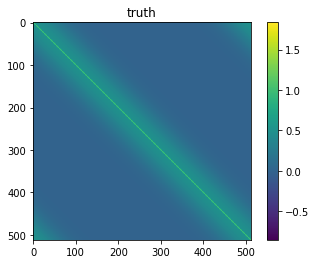

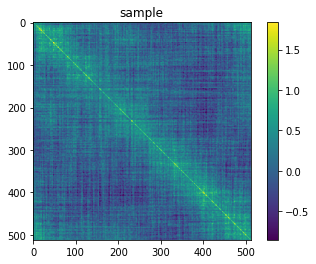

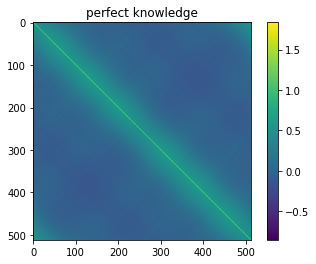

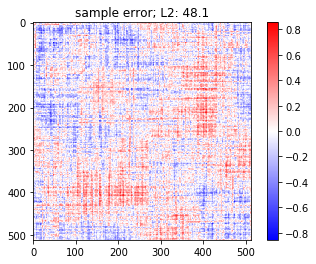

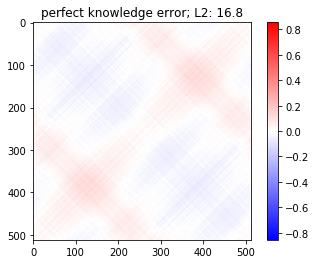

In [244]:
test_trans_matrices(P=P,
                    P_sample=P_sample,
                    P_sqrt=P_sqrt,
                    P_inv_sqrt=P_inv_sqrt,
                    VT=VT,
                    title='perfect knowledge')

array([[0.42705402, 0.4270072 , 0.42686813, ..., 0.42663549, 0.42686813,
        0.4270072 ],
       [0.4270072 , 0.42707908, 0.42705867, ..., 0.4262329 , 0.42658402,
        0.4268417 ],
       [0.42686813, 0.42705867, 0.42715694, ..., 0.42573841, 0.42620784,
        0.42658402],
       ...,
       [0.42663549, 0.4262329 , 0.42573841, ..., 0.42728471, 0.42716151,
        0.42694461],
       [0.42686813, 0.42658402, 0.42620784, ..., 0.42716151, 0.42715694,
        0.42705867],
       [0.4270072 , 0.4268417 , 0.42658402, ..., 0.42694461, 0.42705867,
        0.42707908]])

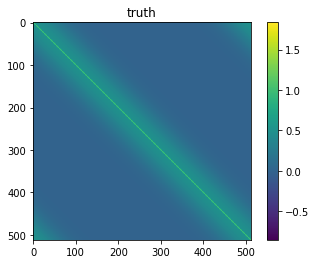

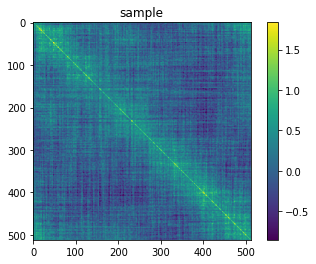

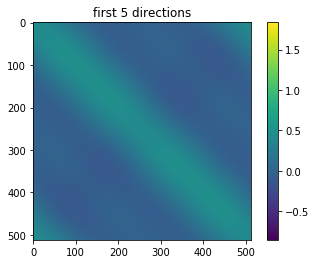

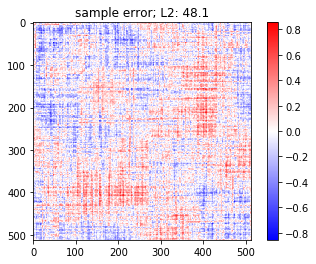

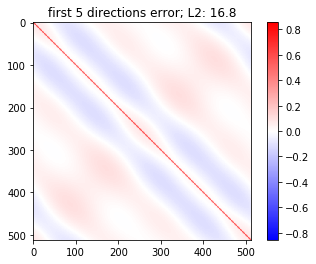

In [245]:
sig_num = 5
test_trans_matrices(P=P,
                    P_sample=P_sample,
                    P_sqrt=P_sqrt,
                    P_inv_sqrt=P_inv_sqrt,
                    VT=VT[:sig_num],
                    title=f'first {sig_num} directions')

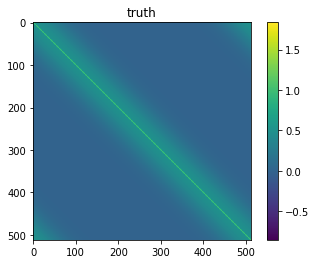

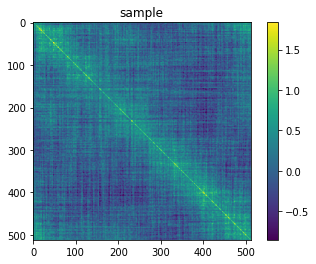

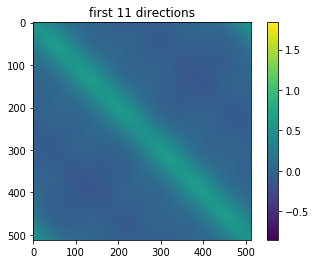

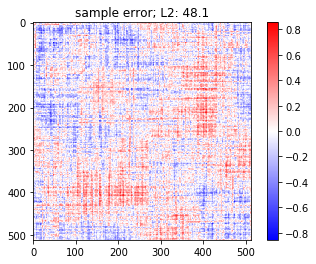

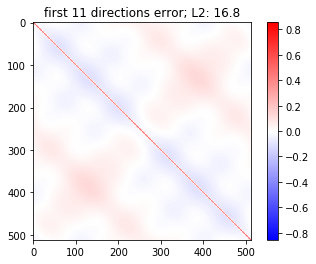

In [246]:
sig_num = 11
P_sample_loc = test_trans_matrices(P=P,
                    P_sample=P_sample,
                    P_sqrt=P_sqrt,
                    P_inv_sqrt=P_inv_sqrt,
                    VT=VT[:sig_num],
                    title=f'first {sig_num} directions')

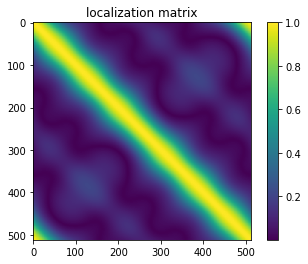

In [247]:
n = 1
P_n = (np.abs(P_sample_loc)**n)
loc = np.diag(np.diag(1/np.sqrt(P_n))) @ P_n @ np.diag(np.diag(1/np.sqrt(P_n)))
imshow(loc, title='localization matrix')

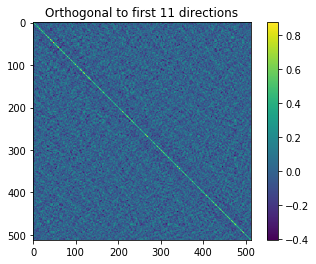

In [248]:
proj = np.eye(dimension) - VT[:sig_num].T @ VT[:sig_num]
imshow(proj @ P_sample @ proj, title='Orthogonal to first 11 directions')

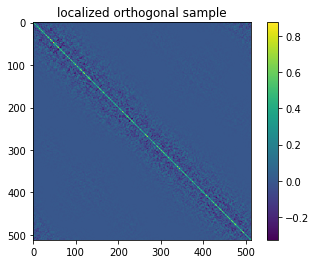

In [249]:
localized_orthogonal = loc * (proj @ P_sample @ proj)
imshow(localized_orthogonal, title='localized orthogonal sample')

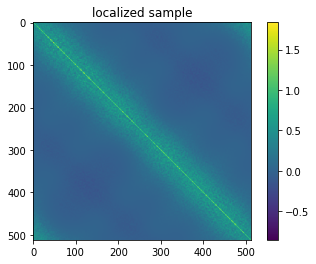

In [252]:
vmax = np.max([P_sample.max(),
               (P_sample_loc + localized_orthogonal).max(),
               P.max()])
vmin = np.min([P_sample.min(),
               (P_sample_loc + localized_orthogonal).min(),
               P.min()])
imshow(P_sample_loc + localized_orthogonal,
       title='localized sample',
       vmin=vmin,
       vmax=vmax)

1


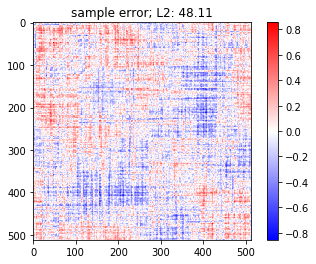

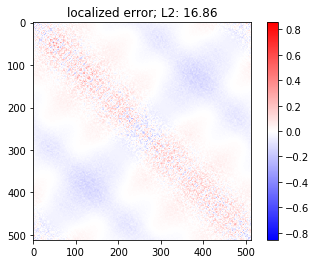

In [251]:
print(n)
error_sample = (P_sample - P)
error_localized = (P_sample_loc + localized_orthogonal) - P
L2_sample = np.round(np.linalg.norm(error_sample, ord=2), decimals=2)
L2_localized = np.round(np.linalg.norm(error_localized, ord=2), decimals=2)
vmax = np.max([np.abs(error_sample).max(), np.abs(error_localized).max()])
imshow(error_sample, vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'sample error; L2: {L2_sample}')
imshow(error_localized, vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'localized error; L2: {L2_localized}')

In [258]:
ens_size = 500
X_large = assimilate.generate_ensemble(ens_size=ens_size,
                                       mu=np.zeros(dimension),
                                       eig_val=eig_val,
                                       eig_vec=eig_vec
                                       )
P_sample_large = np.cov(X_large)

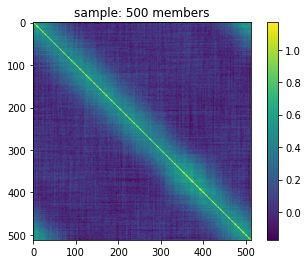

In [259]:
imshow(P_sample_large, title=f'sample: {ens_size} members')

In [260]:
subnum = 16
X_subgrid = X_large.reshape(dimension // subnum, subnum, ens_size)
X_subgrid = X_subgrid.mean(axis=1)
P_sample_subgrid = np.cov(X_subgrid)

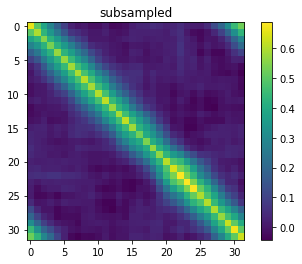

In [262]:
imshow(P_sample_subgrid, title='subsampled')

In [263]:
H_subgrid = np.eye(P_sample_subgrid.shape[0])
R_subgrid = R_sig * np.eye(P_sample_subgrid.shape[0])
trans_mats = assimilate.transformation_matrices(
    H_subgrid, P=P_sample_subgrid,
    R=R_subgrid, return_Ts=True)

for key, val in trans_mats.items():
    key = key + '_subgrid'
    print(key)
    exec(key + '=val')

P_sqrt_subgrid
P_inv_sqrt_subgrid
R_sqrt_subgrid
R_inv_sqrt_subgrid
U_subgrid
S_subgrid
VT_subgrid
H_subgrid
Tx_subgrid
Tx_inv_subgrid
Ty_subgrid
Ty_inv_subgrid


In [264]:
x_interp = np.arange(dimension)
# x_data = np.concatenate(
#     [x_interp[::subnum], [x_interp[-1] + 1]]) + 3.5
x_data = x_interp.reshape(int(dimension/subnum), subnum).mean(axis=1)
x_data = np.concatenate([[x_data[0] - subnum],
                         x_data,
                         [x_data[-1] + subnum]])
# x_data = np.concatenate(
#     [x_interp[::subnum], [x_interp[-1] + 1]]) + 3.5

In [265]:
VT_data = np.concatenate([VT_subgrid[:, -1][:, None],
                          VT_subgrid,
                          VT_subgrid[:, 0][:, None]],
                         axis=1)

In [266]:
interp_kind = 'cubic'
VT_fun = interpolate.interp1d(x_data, VT_data, kind=interp_kind, axis=1)

In [267]:
VT_subgrid_interp = VT_fun(x_interp)/np.sqrt(subnum)

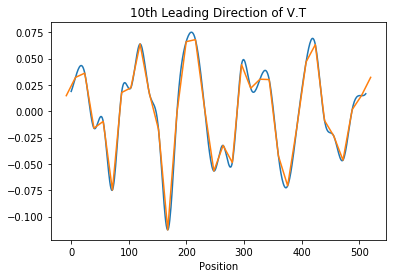

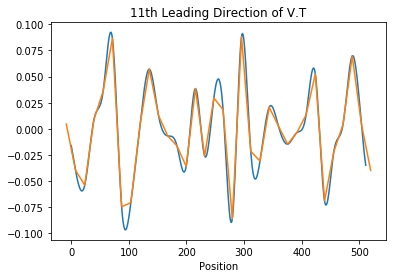

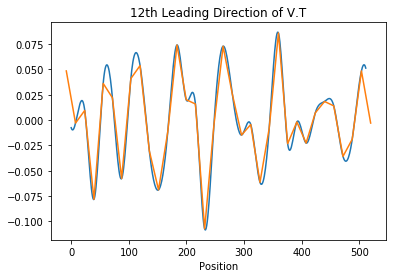

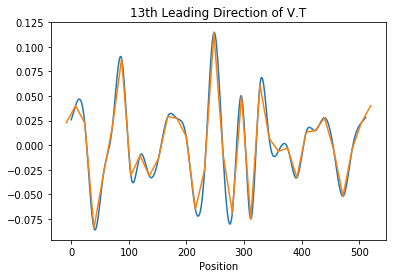

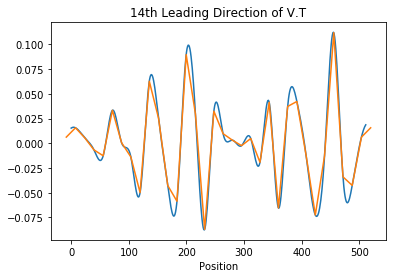

In [321]:
for ii in range(5):
    ii = ii + 10
    plt.figure()
    plt.plot(VT_subgrid_interp[ii])
    plt.plot(x_data, VT_data[ii]/np.sqrt(subnum))
    plt.title(f'{ii}th Leading Direction of V.T')
    plt.xlabel('Position')

In [269]:
U_data = np.concatenate([U_subgrid[-1, :][None, :],
                         U_subgrid,
                         U_subgrid[0, :][None, :]],
                        axis=0)

In [270]:
U_fun = interpolate.interp1d(x_data, U_data, kind=interp_kind, axis=0)

In [271]:
subnum

16

In [272]:
U_subgrid_interp = U_fun(x_interp)/np.sqrt(subnum)

In [273]:
%matplotlib inline

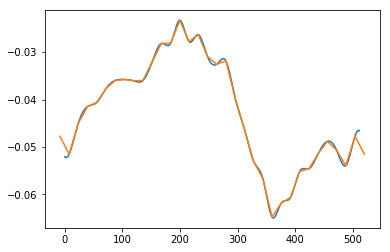

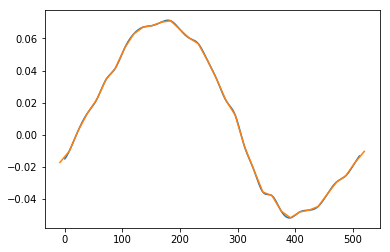

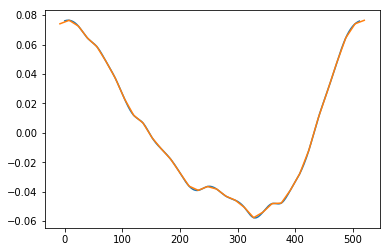

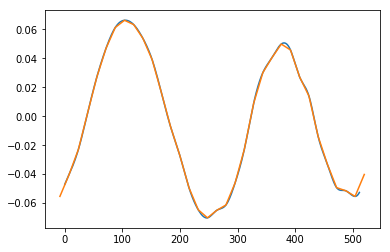

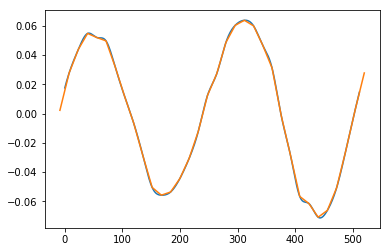

In [274]:
for ii in range(5):
    plt.figure()
    plt.plot(U_subgrid_interp[:, ii])
    plt.plot(x_data, U_data[:, ii]/np.sqrt(subnum))

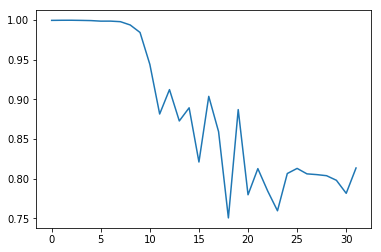

In [275]:
plt.plot(np.diag(U_subgrid_interp.T @ U_subgrid_interp))

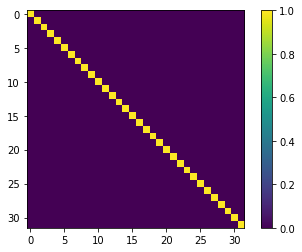

In [276]:
imshow(U_subgrid.T @ U_subgrid)

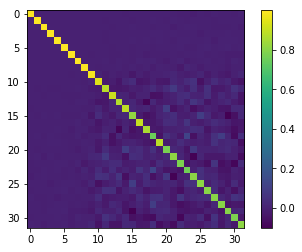

In [277]:
imshow(U_subgrid_interp.T @ U_subgrid_interp)

Text(0.5, 0, 'Component #')

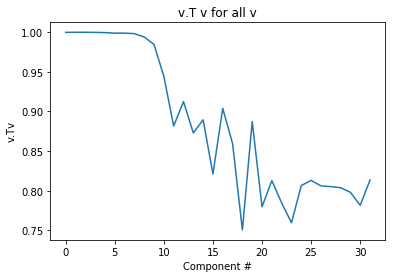

In [283]:
plt.figure()
plt.plot(np.diag(VT_subgrid_interp @ VT_subgrid_interp.T))
plt.title('v.T v for all v')
plt.ylabel('v.Tv')
plt.xlabel('Component #')

Text(0.5, 0, 'Component #')

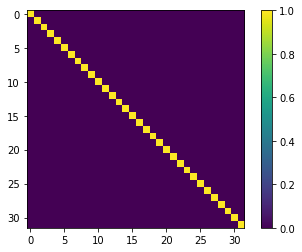

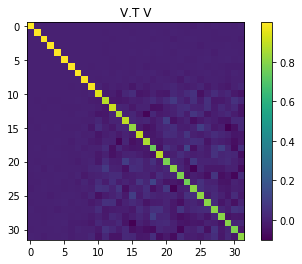

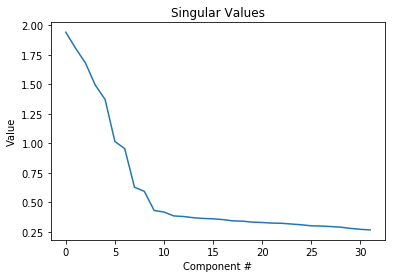

In [287]:
imshow(VT_subgrid @ VT_subgrid.T)
imshow(VT_subgrid_interp @ VT_subgrid_interp.T, title='V.T V')
plt.figure()
plt.plot(np.diag(S_subgrid))
plt.title('Singular Values')
plt.ylabel('Value')
plt.xlabel('Component #')

In [289]:
S_subgrid_interp = S_subgrid * np.sqrt(subnum)

In [290]:
subgrid_sig_num = 11

In [291]:
P_sample_interp_sqrt = (
    U_subgrid_interp[:, :subgrid_sig_num]
    @ S_subgrid_interp[:subgrid_sig_num, :subgrid_sig_num]
    @ VT_subgrid_interp[:subgrid_sig_num, :])
P_sample_interp = P_sample_interp_sqrt @ P_sample_interp_sqrt

In [292]:
%matplotlib notebook

In [293]:
%matplotlib inline

In [294]:
P_sample_interp.trace()/dimension

0.5303446049381135

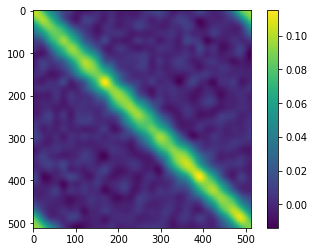

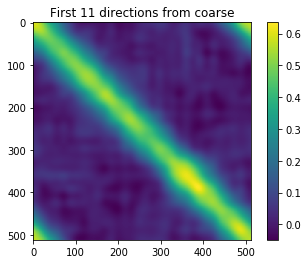

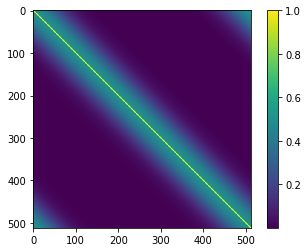

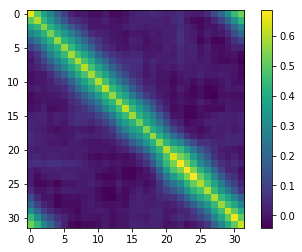

In [308]:
imshow(P_sample_interp_sqrt)
imshow(P_sample_interp_sqrt @ P_sample_interp_sqrt, title='First 11 directions from coarse')
imshow(P)
imshow(P_sample_subgrid)

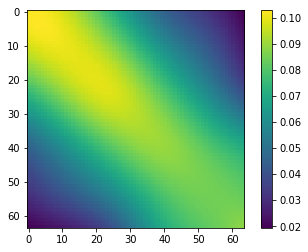

In [296]:
imshow(P_sample_interp_sqrt[:64, :64])

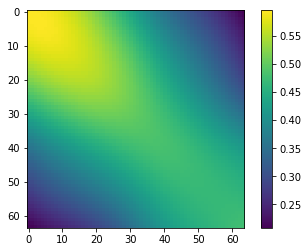

In [297]:
P_sample_interp = P_sample_interp_sqrt @ P_sample_interp_sqrt
imshow(P_sample_interp[:64, :64])

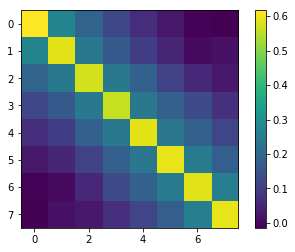

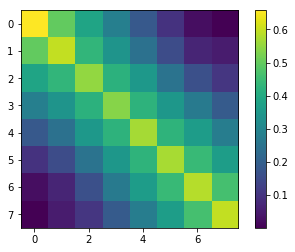

In [298]:
this = U_subgrid @ S_subgrid @ VT_subgrid
that = this @ this
imshow(this[:8, :8])
imshow(that[:8, :8])

In [299]:
ens_size = 30
X = assimilate.generate_ensemble(ens_size=ens_size,
                                       mu=np.zeros(dimension),
                                       eig_val=eig_val,
                                       eig_vec=eig_vec
                                       )
P_sample = np.cov(X)

In [300]:
# P_sample_til = VT_subgrid_interp @ P_inv_sqrt @ P_sample @ P_inv_sqrt @ VT_subgrid_interp.T
P_sample_til = VT_subgrid_interp @ P_sample @ VT_subgrid_interp.T

# P_sample_til = P_inv_sqrt @ P_sample @ P_inv_sqrt

In [301]:
proj = (np.eye(dimension) - VT_subgrid_interp[:subgrid_sig_num].T @ VT_subgrid_interp[:subgrid_sig_num])

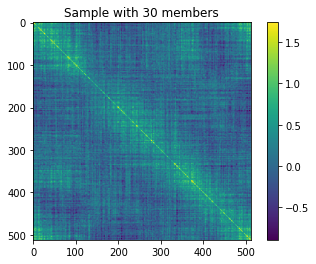

In [307]:
imshow(P_sample, f'Sample with {ens_size} members')

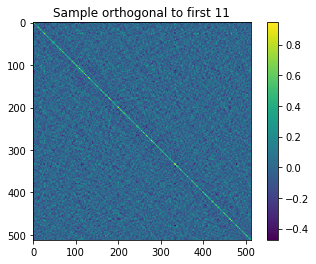

In [309]:
P_orth = proj @ P_sample @ proj
imshow(P_orth, 'Sample orthogonal to first 11')

In [ ]:
def loc_with_trans(P_sample, P_sqrt, P_inv_sqrt, VT):
    P_til_loc = np.diag(np.diag(
        VT @ P_inv_sqrt @ P_sample @ P_inv_sqrt @ VT.T))
    P_sample_loc = P_sqrt @ VT.T @ P_til_loc @ VT @ P_sqrt
    return P_sample_loc

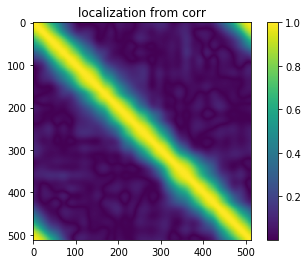

In [310]:
n = 1
P_n = (np.abs(P_sample_interp)**n)
loc = np.diag(np.diag(1/np.sqrt(P_n))) @ P_n @ np.diag(np.diag(1/np.sqrt(P_n)))
imshow(loc, 'localization from corr')

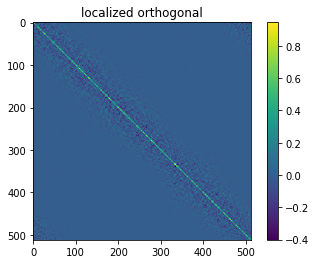

In [311]:
imshow(loc * P_orth, title='localized orthogonal')

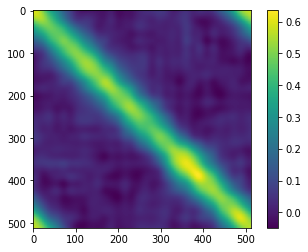

In [312]:
imshow(P_sample_interp)

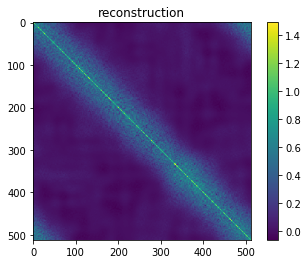

In [314]:
P_sample_loc = P_sample_interp + loc * P_orth
imshow(P_sample_loc, title='reconstruction')

1


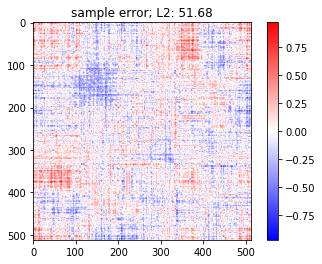

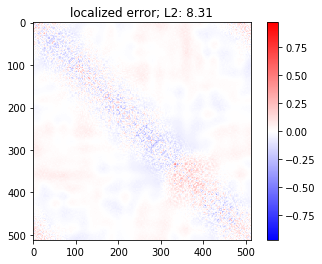

In [315]:
print(n)
error_sample = (P_sample - P)
error_localized = (P_sample_loc) - P
L2_sample = np.round(np.linalg.norm(error_sample, ord=2), decimals=2)
L2_localized = np.round(np.linalg.norm(error_localized, ord=2), decimals=2)
vmax = np.max([np.abs(error_sample).max(), np.abs(error_localized).max()])
imshow(error_sample, vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'sample error; L2: {L2_sample}')
imshow(error_localized, vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'localized error; L2: {L2_localized}')

In [ ]:
imshow(proj @ P_sample @ proj)

In [ ]:
subgrid_dim = P_sample_subgrid.shape[0]
imshow(P_sample_til)

In [ ]:
rho = np.arange(subgrid_dim)[None, :]
rho = np.abs(rho - rho.T)
rho0 = .5
loc = covariance.correlation_sqd_exp(rho=rho, rho0=rho0)

In [ ]:
P_sample_til_loc = P_sample_til * loc

In [ ]:
imshow(P_sample_til_loc)

In [ ]:
# P_sample_loc = P_sqrt @ VT_subgrid_interp.T @ P_sample_til_loc @ VT_subgrid_interp @ P_sqrt
P_sample_loc = VT_subgrid_interp.T @ P_sample_til_loc @ VT_subgrid_interp

In [ ]:
imshow(P_sample)

In [ ]:
imshow(P_sample_interp)

In [ ]:
imshow(P_sample_loc)

In [ ]:
imshow(P)

In [ ]:
imshow(proj)

In [ ]:
S_subgrid.shape

In [ ]:
VT_subgrid_interp.shape

In [ ]:
U_subgrid_interp.shape

In [ ]:
P_sample_interp.shape

In [ ]:
X_til = VT @ P_inv_sqrt @ X
P_sample_til = np.cov(X_til)

rho_smooth = 100
X_smooth = ndimage.gaussian_filter1d(X, sigma=rho_smooth, mode='wrap', axis=0)
X_til_smooth = VT @ P_inv_sqrt @ X_smooth
P_sample_til_smooth = np.cov(X_til_smooth)

In [ ]:
plt.figure()
plt.plot(X[:, 0])

plt.figure()
plt.plot(X_smooth[:, 0])

In [ ]:
imshow(P_sample_til)
imshow(P_sample_til_smooth)

In [ ]:
rho = np.arange(dimension)[None, :]
rho = np.abs(rho - rho.T)

In [ ]:
imshow(rho)

In [ ]:
rho0 = 5
loc = covariance.correlation_sqd_exp(rho=rho, rho0=rho0)

In [ ]:
P_sample_til_loc_smooth = loc * P_sample_til_smooth
# P_sample_til_loc_smooth = np.diag(np.diag(P_sample_til_loc_smooth))
P_sample_til_loc = loc * P_sample_til
# P_sample_til_loc = np.diag(np.diag(P_sample_til))

In [ ]:
imshow(P_sample_til)
imshow(P_sample_til_smooth)
# imshow(loc)
imshow(P_sample_til_loc)
imshow(P_sample_til_loc_smooth)

In [ ]:
# P_sample_til_loc_sqrt = np.real(covariance.matrix_sqrt(C=P_sample_til_loc))
# P_sample_til_loc_sqrt_smooth = np.real(covariance.matrix_sqrt(C=P_sample_til_loc_smooth))

In [ ]:
# X_til_loc = assimilate.generate_ensemble(ens_size=ens_size*1000,
#                                          mu=np.zeros(dimension),
#                                          P_sqrt=P_sample_til_loc_sqrt)

In [ ]:
# X_loc = P_sqrt @ VT.T @ X_til_loc

In [ ]:
# imshow(P_sample_til_loc)

In [ ]:
# P_sample_loc = np.cov(X_loc)

In [ ]:
P_sample_loc = P_sqrt @ VT.T @ P_sample_til_loc @ VT @ P_sqrt
P_sample_loc_smooth = P_sqrt @ VT.T @ P_sample_til_loc_smooth @ VT @ P_sqrt

In [ ]:
imshow(P_sample)
imshow(P_sample_loc)
imshow(P_sample_loc_smooth)
imshow(0.5*(P_sample_loc + 3.5*P_sample_loc_smooth))
imshow(P)

In [ ]:
err_loc_smooth = P - P_sample_loc_smooth
L2_loc_smooth = np.linalg.norm(err_loc_smooth, ord=2)
err_loc = P - P_sample_loc
L2_loc = np.linalg.norm(err_loc, ord=2)
err = P - P_sample
L2 = np.linalg.norm(err, ord=2)
vmax = np.max(
    [np.abs(err_loc_smooth).max(),
     np.abs(err_loc).max(),
     np.abs(err).max()])
imshow(err_loc_smooth,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'Localized error; L2: {L2_loc_smooth}')
imshow(err_loc,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'Localized error; L2: {L2_loc}')
imshow(err,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'Unlocalized error; L2: {L2}')